In [17]:
import os
import sys
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.environ.get('base_path'))

In [18]:
import pandas as pd
import numpy as np

from scipy.stats import friedmanchisquare
from scipy import stats
from scikit_posthocs import posthoc_nemenyi_friedman

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
data = pd.read_csv('Text Classification Project - Model Results - Sheet1.csv')
data.head()

,Model,Dataset,Accuracy,F1,Recall,Precision
0,BERT Embeddings SVM (RBF),sales,97.31%,97.30%,97.31%,97.29%
1,Paraphrase MiniLM Embeddings SVM (RBF),sales,97.27%,97.27%,97.31%,97.23%
2,Paraphrase MiniLM Embeddings AdaBoost (Random ...,sales,96.46%,96.45%,96.46%,96.46%
3,XLM RoBERTa Embeddings AdaBoost (Random Forest),sales,95.82%,95.80%,95.82%,95.88%
4,BERT Embeddings AdaBoost (Random Forest),sales,95.46%,95.44%,95.46%,95.55%


In [20]:


# Convert metric columns from percentages to floats
data[['Accuracy', 'F1', 'Recall', 'Precision']] = data[['Accuracy', 'F1', 'Recall', 'Precision']].replace('%', '', regex=True).astype(float)

# Group data by model and compute average metrics across both datasets for each model
model_performance = data.groupby('Model')[['Accuracy', 'F1', 'Recall', 'Precision']].mean()

# Convert to ranks across models for each metric
ranks = model_performance.rank(ascending=False)

# Perform the Friedman test across the models for each metric
friedman_test_results = {
    metric: friedmanchisquare(*[ranks[metric][ranks.index == model] for model in ranks.index])
    for metric in ranks.columns
}

# Show the Friedman test results
friedman_test_results

{'Accuracy': FriedmanchisquareResult(statistic=16.0, pvalue=0.45296080948699446),
 'F1': FriedmanchisquareResult(statistic=16.0, pvalue=0.45296080948699446),
 'Recall': FriedmanchisquareResult(statistic=16.0, pvalue=0.45296080948699446),
 'Precision': FriedmanchisquareResult(statistic=16.0, pvalue=0.45296080948699446)}


Mean ranks across datasets:
Distilled RoBERTa Fine Tuned: 4.50
BERT Fine Tuned: 5.50
Paraphrase MiniLM Embeddings SVM (RBF): 6.50
BERT Embeddings SVM (RBF): 7.00
XLM RoBERTa Embeddings AdaBoost (Random Forest): 7.00
XLM RoBERTa Embeddings Bi LSTM 6 Layers: 8.00
GPT-4o Fine Tuned: 8.50
Paraphrase MiniLM Embeddings AdaBoost (Random Forest): 8.50
XLM RoBERTa Embeddings Bi LSTM 5 Layers: 9.50
XLM RoBERTa Embeddings XGBoost: 9.50
GPT-4o: 9.50
XLM RoBERTa Embeddings SVM (RBF): 10.00
Paraphrase MiniLM Embeddings XGBoost: 10.00
XLM RoBERTa Embeddings LSTM: 10.50
BERT Embeddings AdaBoost (Random Forest): 10.50
BERT Embeddings XGBoost: 12.00
XLM RoBERTa Embeddings Tree Classifier: 16.00

Friedman test results:
Statistic: 8.90
p-value: 0.9174

Top 3 models by average accuracy:
Distilled RoBERTa Fine Tuned: 94.10%
No statistically significant difference with other models
BERT Fine Tuned: 93.05%
No statistically significant difference with other models
XLM RoBERTa Embeddings Bi LSTM 6 Layers: 91.6

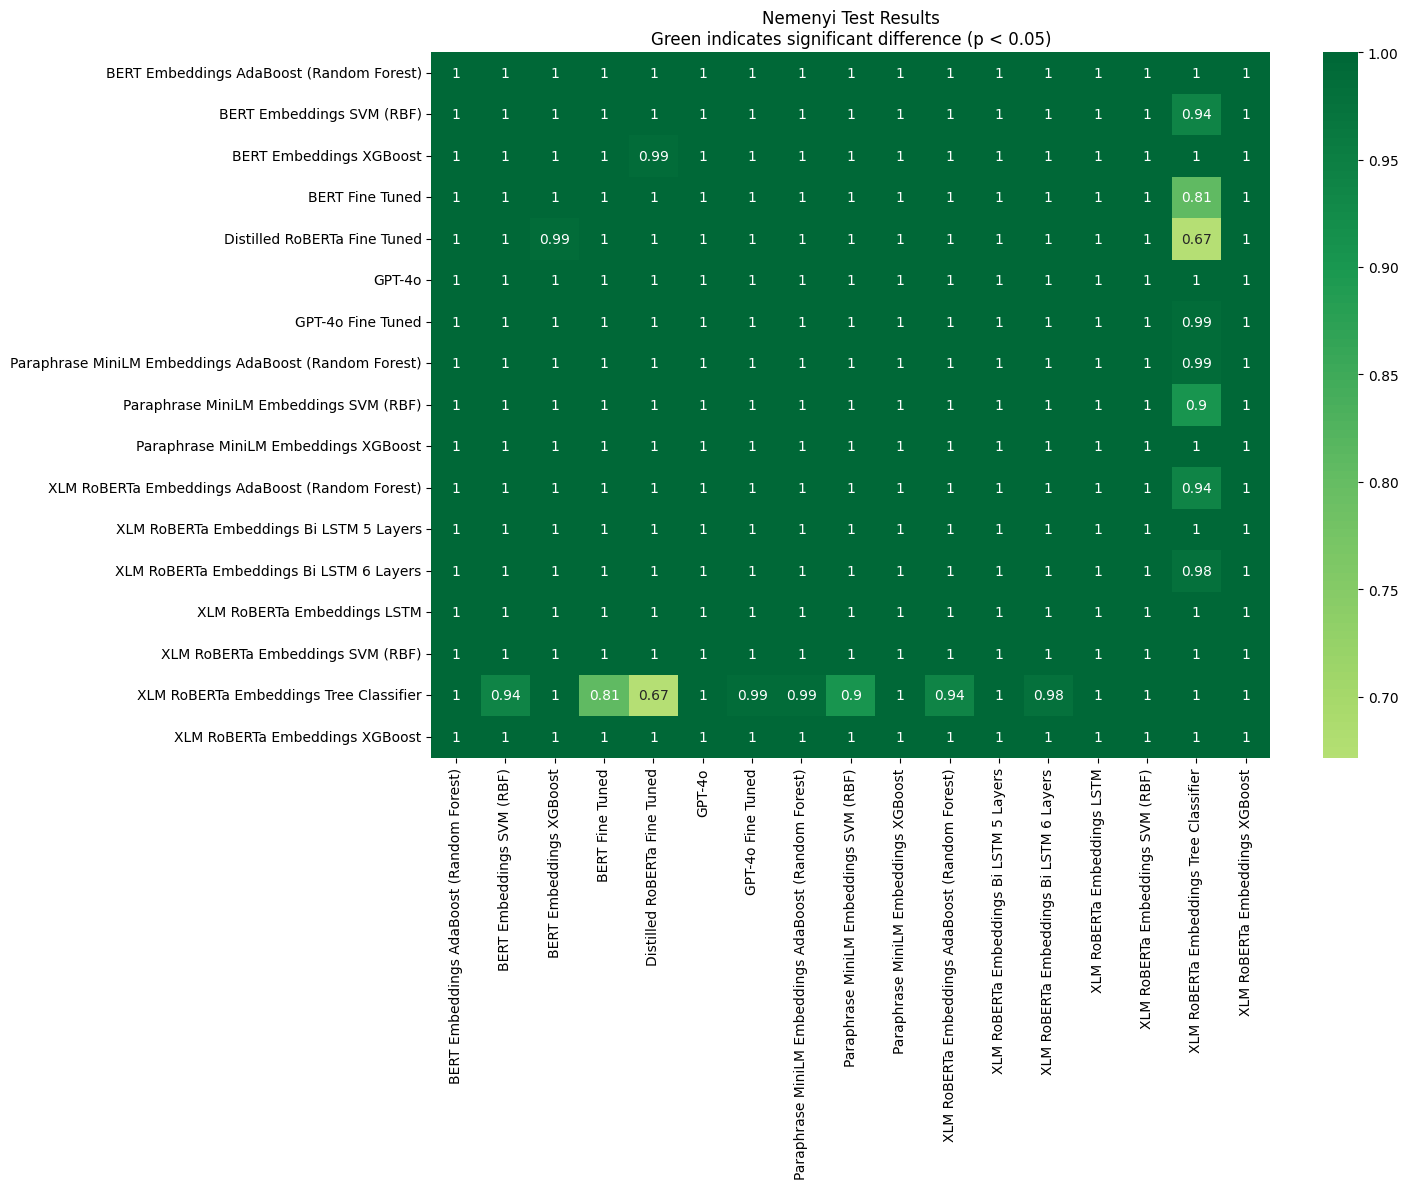

In [26]:
pivot_data = data.pivot(index='Dataset', columns='Model', values='Accuracy')

# Calculate average rank across datasets for each model
ranks = pivot_data.rank(axis=1, ascending=False)
mean_ranks = ranks.mean()
print("\nMean ranks across datasets:")
for model, rank in mean_ranks.sort_values().items():
    print(f"{model}: {rank:.2f}")

# Perform Friedman test
friedman_statistic, p_value = stats.friedmanchisquare(*[pivot_data[col] for col in pivot_data.columns])
print(f"\nFriedman test results:")
print(f"Statistic: {friedman_statistic:.2f}")
print(f"p-value: {p_value:.4f}")


# Perform Nemenyi post-hoc test
nemenyi_results = posthoc_nemenyi_friedman(pivot_data)

# Create heatmap visualization
plt.figure(figsize=(15, 12))
sns.heatmap(nemenyi_results, annot=True, cmap='RdYlGn', center=0.5)
plt.title('Nemenyi Test Results\nGreen indicates significant difference (p < 0.05)')
plt.tight_layout()

# Function to identify the best performing models
def identify_best_models(mean_ranks, avg_accuracy, nemenyi_results, alpha=0.05):
    # Get top 3 models by average accuracy
    top_models = avg_accuracy.nlargest(3)
    
    print("\nTop 3 models by average accuracy:")
    for model, acc in top_models.items():
        print(f"{model}: {acc:.2f}%")
        
        # Check if this model is significantly better than others
        significant_diff = nemenyi_results.loc[model] < alpha
        better_than = significant_diff[significant_diff].index.tolist()
        if better_than:
            print(f"Significantly better than {len(better_than)} other models")
        else:
            print("No statistically significant difference with other models")

# Identify best models
identify_best_models(mean_ranks, model_avg_accuracy, nemenyi_results)

In [21]:
# sales best models
data[data['Dataset']=='sales'].sort_values(by=['Accuracy', 'F1'], ascending=[False, False])

,Model,Dataset,Accuracy,F1,Recall,Precision
0,BERT Embeddings SVM (RBF),sales,97.31,97.30,97.31,97.29
1,Paraphrase MiniLM Embeddings SVM (RBF),sales,97.27,97.27,97.31,97.23
2,Paraphrase MiniLM Embeddings AdaBoost (Random ...,sales,96.46,96.45,96.46,96.46
3,XLM RoBERTa Embeddings AdaBoost (Random Forest),sales,95.82,95.80,95.82,95.88
4,BERT Embeddings AdaBoost (Random Forest),sales,95.46,95.44,95.46,95.55
5,Distilled RoBERTa Fine Tuned,sales,95.09,95.08,95.09,95.11
6,BERT Fine Tuned,sales,94.66,94.65,94.66,94.67
7,Paraphrase MiniLM Embeddings XGBoost,sales,94.47,94.44,94.47,94.51
8,BERT Embeddings XGBoost,sales,94.41,94.38,94.41,94.43
9,XLM RoBERTa Embeddings XGBoost,sales,94.35,94.31,94.35,94.40


In [22]:
# IMDB best models
data[data['Dataset']=='IMDB'].sort_values(by=['Accuracy', 'F1'], ascending=[False, False])

,Model,Dataset,Accuracy,F1,Recall,Precision
17,GPT-4o Fine Tuned,IMDB,96.50,96.50,96.50,96.50
18,GPT-4o,IMDB,94.90,94.89,94.90,95.09
19,Distilled RoBERTa Fine Tuned,IMDB,93.11,93.11,93.11,93.12
20,BERT Fine Tuned,IMDB,91.43,91.43,91.43,91.45
21,XLM RoBERTa Embeddings Bi LSTM 6 Layers,IMDB,91.15,91.15,91.15,91.17
22,XLM RoBERTa Embeddings SVM (RBF),IMDB,91.11,91.65,92.08,91.23
23,XLM RoBERTa Embeddings Bi LSTM 5 Layers,IMDB,90.82,90.82,90.82,90.84
24,XLM RoBERTa Embeddings LSTM,IMDB,90.70,90.69,90.70,90.71
25,XLM RoBERTa Embeddings XGBoost,IMDB,86.14,86.26,85.78,86.74
26,XLM RoBERTa Embeddings AdaBoost (Random Forest),IMDB,83.64,84.08,85.19,82.99


In [23]:
# Average over both datasets
data.groupby('Model')[['Accuracy', 'F1', 'Recall', 'Precision']].mean().sort_values(by=['Accuracy', 'F1'], ascending=[False, False])

,Accuracy,F1,Recall,Precision
Model,,,,
Distilled RoBERTa Fine Tuned,94.100,94.095,94.100,94.115
BERT Fine Tuned,93.045,93.040,93.045,93.060
XLM RoBERTa Embeddings Bi LSTM 6 Layers,91.665,91.655,91.665,91.655
XLM RoBERTa Embeddings Bi LSTM 5 Layers,91.090,91.055,91.090,91.100
XLM RoBERTa Embeddings LSTM,90.525,90.495,90.525,90.490
XLM RoBERTa Embeddings XGBoost,90.245,90.285,90.065,90.570
Paraphrase MiniLM Embeddings SVM (RBF),90.175,91.000,92.950,89.210
XLM RoBERTa Embeddings AdaBoost (Random Forest),89.730,89.940,90.505,89.435
XLM RoBERTa Embeddings SVM (RBF),89.575,89.955,90.055,89.885


1. Statistical Significance:
* The Friedman test p-value is 0.9174, which is much larger than 0.05, indicating that there is no statistically significant difference between the models overall.<br> This suggests that the performance variations we see might be due to random chance rather than true differences in model capabilities.


2. Best Performing Models:
* Distilled RoBERTa Fine Tuned leads with:
  * Best mean rank (4.50)
  * Highest average accuracy (94.10%)

* BERT Fine Tuned is second with:
  * Mean rank of 5.50
  * Average accuracy of 93.05%

* XLM RoBERTa Embeddings Bi LSTM 6 Layers is third with:
  * Mean rank of 8.00
  * Average accuracy of 91.67%

3. Nemenyi Test Results (from the heatmap):
* The heatmap shows pairwise comparisons between models
* Most values are close to 1.0 (dark green), indicating no significant differences between most model pairs
* Only a few comparisons show lighter green values (e.g., with XLM RoBERTa Embeddings Tree Classifier), suggesting these are the only cases where we see meaningful differences


4. Key Insights:
* The small performance differences between most models are not statistically significant
* Fine-tuned models (Distilled RoBERTa and BERT) consistently perform well across both datasets
* The XLM RoBERTa Tree Classifier performs notably worse than other approaches
* Complex architectures (like LSTM variants) don't necessarily outperform simpler fine-tuned models
* GPT-4o shows inconsistent performance across datasets, suggesting it might not be the best choice for these specific tasks


5. Practical Recommendations:
* Given the lack of statistical significance, you might want to choose models based on other factors like:
  * Inference speed
  * Model size
  * Ease of deployment
  * Resource requirements
* The Distilled RoBERTa Fine Tuned model might be the best choice since it offers:
  * Best average performance
  * Potentially faster inference (being distilled)
  * Consistent performance across both tasks